In [48]:
import re, string 
import pandas as pd 
from time import time  
from collections import defaultdict
from matplotlib import pyplot as plt
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import spacy
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
%matplotlib inline

In [49]:
bbc = pd.read_csv('bbc-text.csv')

In [50]:
bbc.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [51]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    
    if len(text) > 2:
        return ' '.join(word for word in text.split() if word not in STOPWORDS)

bbc_clean = pd.DataFrame(df.text.apply(lambda x: clean_text(x)))

In [52]:
bbc_clean.head()

,text
0,tv future hands viewers home theatre systems p...
1,worldcom boss left books alone former worldcom...
2,tigers wary farrell gamble leicester say rushe...
3,yeading face newcastle fa cup premiership side...
4,ocean twelve raids box office ocean twelve cri...


In [53]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) 

def lemmatizer(text):
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

bbc_clean["text_lemmatize"] =  df_clean.apply(lambda x: lemmatizer(x['text']), axis=1)

In [54]:
bbc_clean.head()

,text,text_lemmatize
0,tv future hands viewers home theatre systems p...,tv future hand viewer home theatre system plas...
1,worldcom boss left books alone former worldcom...,worldcom boss leave book alone former worldcom...
2,tigers wary farrell gamble leicester say rushe...,tigers wary farrell gamble leicester say rush ...
3,yeading face newcastle fa cup premiership side...,yeade face newcastle fa cup premiership side n...
4,ocean twelve raids box office ocean twelve cri...,ocean twelve raid box office ocean twelve crim...


In [55]:
bbc_clean['text_lemmatize_clean'] =bbc_clean['text_lemmatize'].str.replace('-PRON-', '')

In [56]:
sentences = [row.split() for row in bbc_clean['text_lemmatize_clean']]
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

25892

In [57]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['say', 'mr', 'year', 'would', 'make', 'also', 'people', 'new', 'one', 'take']

In [58]:
w2v_model = Word2Vec(min_count=200,
                     window=5,
                     size=100,
                     workers=4)

In [59]:
#Preparing the model vocabulary
w2v_model.build_vocab(sentences)

In [60]:
#Training the model
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)

c:\users\аян\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


(966534, 2384980)

In [61]:
w2v_model.init_sims(replace=True)

In [62]:
#Test: most similiar words for 'us'
w2v_model.wv.most_similar(positive=['us'])

[('trade', 0.8016915321350098),
 ('company', 0.8015249967575073),
 ('group', 0.7964544892311096),
 ('stock', 0.7823858261108398),
 ('china', 0.7640591263771057),
 ('financial', 0.7425346374511719),
 ('share', 0.7355493903160095),
 ('firm', 0.7295226454734802),
 ('oil', 0.7255017757415771),
 ('india', 0.7236635684967041)]

In [64]:
#Test: most similiar words for 'stock'
w2v_model.wv.most_similar(positive=['stock'])

[('india', 0.9701998233795166),
 ('oil', 0.9684049487113953),
 ('china', 0.9522470235824585),
 ('profit', 0.9385466575622559),
 ('trade', 0.921842098236084),
 ('demand', 0.9180200695991516),
 ('share', 0.9156865477561951),
 ('main', 0.9064675569534302),
 ('price', 0.9045817255973816),
 ('boost', 0.9000492691993713)]

In [65]:
# Similarity of two words
w2v_model.wv.similarity('us', 'stock')

0.7823859

In [66]:
def tsne_plot(model, wordSearch):
    labels = []
    tokens = []
    
    tokens.append(model[wordSearch])
    labels.append(wordSearch)

    for word, value in model.wv.most_similar(positive=[wordSearch]):
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(10, 10))
    plt.scatter(x[0],y[0], c='#ff0000')
    plt.annotate(labels[0],
                     xy=(x[0], y[0]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    for i in range(1, len(x)):
        plt.scatter(x[i],y[i], c='#000000')
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [67]:
w2v_model.wv.vocab

{'tv': <gensim.models.keyedvectors.Vocab at 0x2f2838b1288>,
 'future': <gensim.models.keyedvectors.Vocab at 0x2f284bb8688>,
 'hand': <gensim.models.keyedvectors.Vocab at 0x2f284bb8e48>,
 'home': <gensim.models.keyedvectors.Vocab at 0x2f2efa0f188>,
 'system': <gensim.models.keyedvectors.Vocab at 0x2f28c7070c8>,
 'digital': <gensim.models.keyedvectors.Vocab at 0x2f2875648c8>,
 'video': <gensim.models.keyedvectors.Vocab at 0x2f287555f88>,
 'move': <gensim.models.keyedvectors.Vocab at 0x2f285faa7c8>,
 'live': <gensim.models.keyedvectors.Vocab at 0x2f2efa0f0c8>,
 'way': <gensim.models.keyedvectors.Vocab at 0x2f283a840c8>,
 'people': <gensim.models.keyedvectors.Vocab at 0x2f287a59988>,
 'different': <gensim.models.keyedvectors.Vocab at 0x2f287a59d48>,
 'five': <gensim.models.keyedvectors.Vocab at 0x2f284c904c8>,
 'year': <gensim.models.keyedvectors.Vocab at 0x2f284c900c8>,
 'time': <gensim.models.keyedvectors.Vocab at 0x2f284c90688>,
 'accord': <gensim.models.keyedvectors.Vocab at 0x2f284c90

c:\users\аян\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
c:\users\аян\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


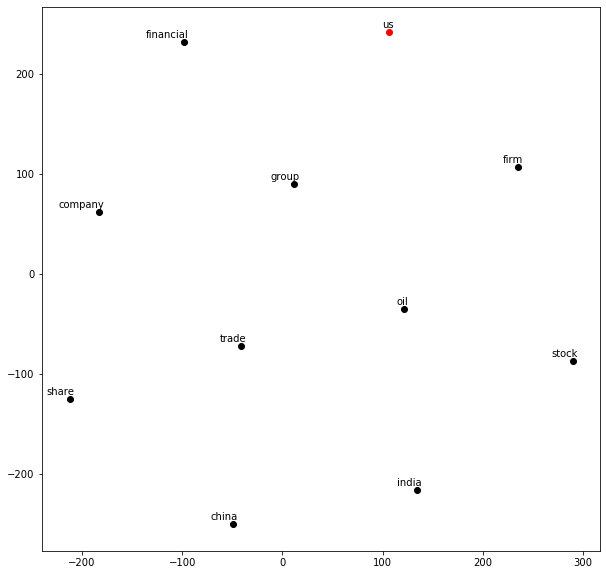

In [68]:
tsne_plot(w2v_model, 'us') #instead of the word "America", I used the word " US"